We first define the activation function that we will use for the neural network. In addition to the forward pass, we also need backward pass. The backward pass is the calculation of the derivative of the loss with respect to the input of the activation function, given that we know the derivative of the loss with respect to the output of the activation function.

In [1]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def softmax(Z):
    output = np.zeros(Z.shape)
    for i in range(Z.shape[0]):
        output[i] = np.exp(Z[i])/np.sum(np.exp(Z[i]))
    return output

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

def softmax_backward(dA, Z):
    dZ = np.zeros((Z.shape[0],Z.shape[1]))
    for i in range(Z.shape[0]):
        dZ[i] = (-Z[np.newaxis,i].T@Z[np.newaxis,i]+np.diag(Z[i]))@dA[i]
    return dZ

We initialize the layers of the neural network. We need the input size and for each layer we need the output size and the activation function. We will use a dictionary to keep the weights and the biases. For the wights and the biases we use a normal distribution with mean 0 and standard deviation 0.1 .

In [2]:
def init_layers(input_size, neural_network, seed = 128):
    np.random.seed(seed)
    weights = {}
    layer_input_size = input_size
    for ind, layer in enumerate(neural_network):
        layer_output_size = layer[0]
        weights['W' + str(ind)] = np.random.randn(layer_input_size, layer_output_size)*0.1
        weights['b' + str(ind)] = np.random.randn(layer_output_size)*0.1
        layer_input_size = layer_output_size
    return weights

The forward pass for a single layer. To be able to use batch input, we will keep the first dimension of the matrices as the index of the inputs.

In [3]:
def single_forward_pass(x, W, b, activation="relu"):

    output = x@W + b
    
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    elif activation == "softmax":
        activation_func = softmax
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(output), output

The forward pass for the whole model. We assume that the input is 2D, with the first dimension corresponding to different inputs. In the case of a single input we add a "dummy" first dimension to the input.

In [4]:
def full_forward_pass(X, params_values, neural_network):
    memory = {}
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    for idx, layer in enumerate(neural_network):
        memory["X" + str(idx)] = X
        
        activ_function = layer[1]
        W = params_values["W" + str(idx)]
        b = params_values["b" + str(idx)]
        X, Z = single_forward_pass(X, W, b, activ_function)
        
        memory["Z" + str(idx)] = Z
    memory["X" + str(idx+1)] = X
    return X, memory

Since we want to train our model on the MNIST dataset which is a classification problem, we will use categorical cross entropy as a loss function.

In [5]:
def cross_entropy_cost(Y_hat, Y):
    temp = softmax(Y_hat)
    cost = 0
    for ind, y in enumerate(Y):
        cost -= np.log(temp[ind][np.argmax(y)])
    return cost

def convert_prob_into_class(Y):
    return np.argmax(Y, axis=1)

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == np.argmax(Y, axis=1)).mean()

We are basically using the chain rule to express the derivative of the loss with respect to the input as the derivative of the loss with respect to the output multiplied by the derivative of the output with respect to the input. For the case of multiple inputs, we are averaging the derivatives, which is the most common case for batch input.

In [6]:
def single_layer_backward_propagation(dX_curr, W_curr, b_curr, Z_curr, X_prev, activation="relu"):
    m = Z_curr.shape[0]
    
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    elif activation == "softmax":
        backward_activation_func = softmax_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dX_curr, Z_curr)
    
    dW_curr = (X_prev.T@dZ_curr) / m
    db_curr = np.sum(dZ_curr, axis=0, keepdims=True) / m
    dX_prev = dZ_curr@W_curr.T
    return dX_prev, dW_curr, db_curr

For the full backward pass we need to use the values we stored in the forward pass. We are also storing the values of the gradients so that we can update the parameters later.

In [7]:
def full_backward_propagation(Y_hat, Y, memory, params_values, neural_network):
    grads_values = {}
    m = Y.shape[0]
    Y = Y.reshape(Y_hat.shape)
    dX_prev = softmax(Y_hat) - Y
    for layer_idx_curr, layer in reversed(list(enumerate(neural_network))):
        activ_function_curr = layer[1]
        dX_curr = dX_prev
        X_prev = memory["X" + str(layer_idx_curr)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dX_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dX_curr, W_curr, b_curr, Z_curr, X_prev, activ_function_curr)
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
        
    return grads_values

We update the parameters based on the learning rate and the gradients.

In [8]:
def update(params_values, grads_values, neural_network, learning_rate):
    for layer_idx, layer in enumerate(neural_network):
        params_values["W" + str(layer_idx)] = params_values["W" + str(layer_idx)] - learning_rate * grads_values["dW" + str(layer_idx)] 
        params_values["b" + str(layer_idx)] = params_values["b" + str(layer_idx)] - learning_rate * grads_values["db" + str(layer_idx)].reshape(params_values["b" + str(layer_idx)].shape)
    return params_values;

We combine the above functions to train our model. We use tqdm to visualize training. We have an optional shuffle parameter such that if it is true we shuffle the input on each epoch.

In [9]:
from tqdm import trange  
     
def train(X, Y, input_size, neural_network, epochs, learning_rates, params_values=None, batch_size = 128, shuffle = True, seed=32):
    if params_values == None:
        params_values = init_layers(input_size, neural_network, seed=seed)
    cost_history = []
    accuracy_history = []
    accuracy = 0
    total_cost = 0
    accuracy = 0
    for learning_rate in learning_rates:
        t = trange(epochs, desc='Loss = {:8.3f}, Accuracy = {:.3f}'.format(total_cost, accuracy), leave=True)
        i = 0
        for _ in t:
            
            t.refresh()
            if shuffle:
                p = np.random.permutation(X.shape[0])
                X = X[p]
                Y = Y[p]
            Y_hat_all = np.zeros((Y.shape[0],Y.shape[1]))
            for batch in range(0,X.shape[0],batch_size):
                X_temp = X[batch:batch+batch_size]
                Y_temp = Y[batch:batch+batch_size]
                Y_hat, cashe = full_forward_pass(X_temp, params_values, neural_network)
                cost = cross_entropy_cost(Y_hat, Y_temp)
                
                Y_hat_all[batch:batch+batch_size] = Y_hat
                grads_values = full_backward_propagation(Y_hat, Y_temp, cashe, params_values, neural_network)
                params_values = update(params_values, grads_values, neural_network, learning_rate)
            total_cost = cross_entropy_cost(Y_hat_all, Y)/X.shape[0]
            cost_history.append(total_cost)
            accuracy = get_accuracy_value(Y_hat_all, Y)
            accuracy_history.append(accuracy)
            i = i + 1
            t.set_description('Loss = {:8.3f}, Accuracy = {:.3f}'.format(total_cost, accuracy))
    return params_values, cost_history, accuracy_history

In [ ]:
Code to download the MNIST dataset.

In [10]:
import numpy as np
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "https://ossci-datasets.s3.amazonaws.com/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]



We load the train and test set.

In [11]:
init()
x_train, t_train, x_test, t_test = load()

Download complete.
Save complete.


Normalize the input to values from 0 to 1.

In [12]:
x_train = np.array(x_train)/255

Shuffle inputs and do one hot encoding of the labels.

In [13]:
p = np.random.permutation(x_train.shape[0])
x_train = x_train[p]
t_train = np.array(t_train)[p]
Y = np.zeros((t_train.shape[0],np.max(t_train)+1))
for i in range(Y.shape[0]):
    Y[i][t_train[i]] = 1

Define and train the model. We use two learning rates. The model will train with the first learning rate for 10 epochs and then continue training for another 10 epochs with the second learning rate.

In [14]:
neural_network = [
    (512, "sigmoid"),
    (128, "relu"),
    (10, "sigmoid"),
]
results = train(x_train, Y, x_train.shape[1], neural_network, epochs=10, learning_rates=[0.1, 0.01], batch_size = 60, shuffle = True, seed = 35)

Loss =    1.532, Accuracy = 0.928: 100%|███████████████████████████████████████████████| 10/10 [02:13<00:00, 13.33s/it]


Make predictions on the test set and do one hot encoding of the test set.

In [15]:
x_test = np.array(x_test)/255
Y_pred, cashe = full_forward_pass(x_test, results[0], neural_network)
predictions = softmax(Y_pred)
t_test = np.array(t_test)
Y_test = np.zeros((t_test.shape[0],np.max(t_test)+1))

for i in range(Y_test.shape[0]):
    Y_test[i][t_test[i]] = 1


Plot training loss and accuracy.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Accuracy')

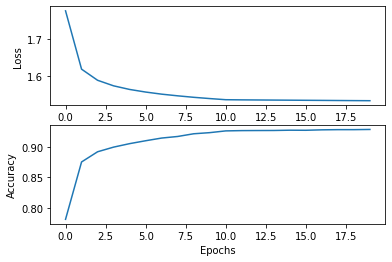

In [17]:
plt.subplot(2, 1, 1)
plt.plot(results[1], label='Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(2, 1, 2)
plt.plot(results[2], label='Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Calculate test accuracy and make some sample predictions.

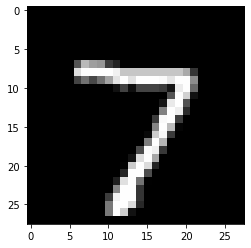

The predicted class is 7



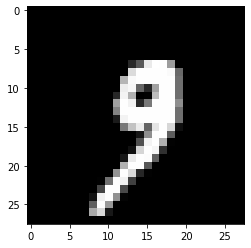

The predicted class is 9



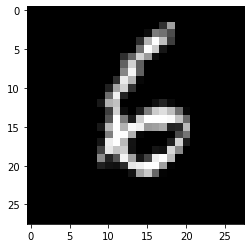

The predicted class is 6



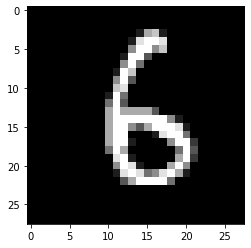

The predicted class is 6



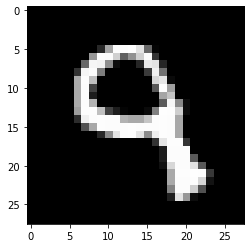

The predicted class is 4



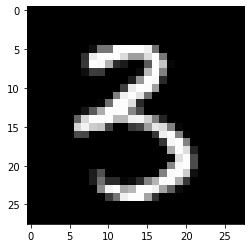

The predicted class is 3



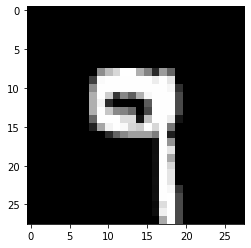

The predicted class is 9



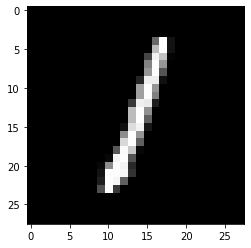

The predicted class is 1



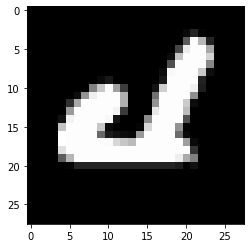

The predicted class is 4



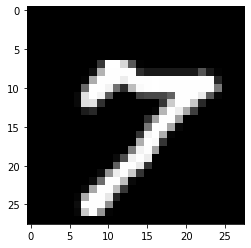

The predicted class is 7

Test accuracy is 92.71%


In [18]:
correct = 0
for i in range(x_test.shape[0]):
    # plot the sample
    if np.argmax(Y_test[i]) == np.argmax(predictions[i]):
        correct = correct + 1
    if i%1000 == 0:
        fig = plt.figure
        plt.imshow(x_test[i].reshape((28,28)), cmap='gray')
        plt.show()
        print("The predicted class is " + str(np.argmax(predictions[i])))
        print('')
print('Test accuracy is {:.2f}%'.format(100*correct/x_test.shape[0]))   